# 0 Setup

### Imports

In [40]:
import os           # file operations
import sys          # system operations
import re           # regular expressions
import pandas as pd # data manipulation
import openai       # OpenAI API

# Get the current working directory (assuming the notebook is in the notebooks folder)
current_dir = os.getcwd()

# Add the parent directory (project root) to the Python path to enable relative imports (from src)
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from src.openai import OpenAIModels, CustomOpenAIClient
from src.embeddings import EmbeddingAnalyzer

### API key
**WARNING**: Do not share any code or commit it to git which includes readable API Keys.

In [41]:
# OpenAI API key
# https://help.openai.com/en/articles/5112595-best-practices-for-api-key-safety

######### EDIT ############
# TODO: Comment out the first line, uncomment the second line below and replace the placeholder with your API key
openai.api_key = os.environ["OPENAI_API_KEY"]
# openai.api_key = "YOUR_API_KEY"
###########################

### Parameter

In [43]:
# Set the paths
input_dir = os.path.join(parent_dir, 'data', 'input')
processed_dir = os.path.join(parent_dir, 'data', 'processed')

######### EDIT ############
# TODO: Adapt the file name, if necessary
# input_file = '2024-06-20_Combined sources_removed exact duplicates.xlsx'
input_file = '2024-06-22_Combined_incl nonprofits_removed exact duplicates.xlsx'

# TODO: Adapt the folder name, if necessary
output_dir = os.path.join(processed_dir, '2024-06-22_02_Nonprofits')
###########################

# Create the output directory if it does not exist
os.makedirs(output_dir, exist_ok=True)

# 1 Preprocessing

### Loading the data

In [45]:
df = pd.read_excel(os.path.join(input_dir, input_file))

# Calculate an information value which counts for each row how many columns are not NaN (i.e. contain information) + the length of the abstract (normalized by the mean length)
df['InformationValue'] = df.notna().sum(axis=1) + df['Abstract'].str.len() / df['Abstract'].str.len().mean()

print(f"Shape: {df.shape}")

# Rename the column "Date" to "Year", if "Year" does not exist and "Date" does
if "Year" not in df.columns and "Date" in df.columns:
    df.rename(columns={"Date": "Year"}, inplace=True)

# Sort the data frame by the "Title" column in descending order
df.sort_values(by="Title", ascending=True, inplace=True)

df.iloc[30:40]

Shape: (14871, 21)


,Title,Authors,Journal,Publication,Pages,Year,Paper type,Abstract,DE,Subject terms,...,Company Entity,NAICS Code,Address,FT,ISSN,DOI,Accession number,UR,Source,InformationValue
40,2030 Agenda and sustainable business models in...,"Rosato, Pier Felice; Caputo, Andrea; Valente, ...",ECOLOGICAL INDICATORS,NaN,10,2021,Review,"Starting in 2015, 169 states launched a series...",NaN,DEVELOPMENT GOALS; MANAGEMENT; CONSERVATION; E...,...,NaN,NaN,"[Rosato, Pier Felice; Pizzi, Simone] Univ Sale...",NaN,1470-160X,10.1016/j.ecolind.2020.106978,NaN,NaN,WOS,13.586635
41,21ST CENTURY COMMUNITY LEARNING CENTERS--IMPRO...,"Dodd, Arleen T. 1; Bowen, Lizette M.",Journal of Health & Human Services Administration,"Jun2011, Vol. 34 Issue 1, p10-41",32p,2011,Article,The authors of this article report on an inter...,Nonprofit organizations; Academic support prog...,After school programs; High school students; T...,...,NaN,813319 Other Social Advocacy Organizations; 61...,1 State University of New York College at Old ...,NaN,10793739,10.1177/107937391103400102,61775225,https://search.ebscohost.com/login.aspx?direct...,EBSCO,17.775179
42,2D lamellar membrane with MXene hetero-interca...,"Ma, Xinyu; Wang, Aiqi; Miao, Jinlei; Fan, Ting...",SEPARATION AND PURIFICATION TECHNOLOGY,NaN,11,2023,Article,Efficient wastewater treatment under harsh con...,NaN,NANOFILTRATION MEMBRANES; COMPOSITE MEMBRANE; ...,...,NaN,NaN,"[Ma, Xinyu; Miao, Jinlei; Fan, Tingting] Qingd...",NaN,1383-5866,10.1016/j.seppur.2023.123248,NaN,NaN,WOS,13.838193
43,3 MARIAS: DE MULHERES PARA MULHERES.,"Menegon, Leticia Fantinato 1 leticia.menegon...",Revista de Empreendedorismo e Gestão de Pequen...,"Jan-Apr2022, Vol. 11 Issue 1, p1-18",18p,2022,Article,Objective of the case: Help students to evalua...,Business incubators; Social impact; Business m...,Model validation,...,NaN,NaN,1 Escola de Administração de Empresas de São P...,NaN,23162058,10.14211/regepe.e2012,156042535,https://search.ebscohost.com/login.aspx?direct...,EBSCO,18.639378
44,30 Years of foreign direct investment to China...,"Fetscherin, Marc 1,2 mfetscherin@rollins.edu...",International Business Review,"Jun2010, Vol. 19 Issue 3, p235-246",12p,2010,Article,Abstract: The purpose of this paper is to exam...,Foreign investments; Economics education; Inte...,Bibliometrics; Citation networks; Literature r...,...,NaN,928120 International Affairs; 911410 Foreign a...,"1 Crummer Graduate School of Business, Rollins...",NaN,09695931,10.1016/j.ibusrev.2009.12.002,50358028,https://search.ebscohost.com/login.aspx?direct...,EBSCO,18.880703
45,3D TECHNOLOGIES AND CREATIVITY IN CHILDHOOD ED...,"Serrano, Noemi; Pocinho, Margarida; Farnicka, ...",9TH INTERNATIONAL CONFERENCE ON EDUCATION AND ...,NaN,8,2017,Proceedings Paper,The social changes and the future needs that t...,NaN,NaN,...,NaN,NaN,"[Serrano, Noemi] Univ Cadiz, Cadiz, Spain; [Po...",NaN,2340-1117,NaN,NaN,NaN,WOS,11.982727
46,50 years of social marketing: seeding solution...,"Dietrich, Timo; Hurley, Erin; Carins, Julia; K...",EUROPEAN JOURNAL OF MARKETING,NaN,30,2022,Article,Purpose The purpose of this paper is synthesis...,NaN,INCREASE PHYSICAL-ACTIVITY; INTIMATE PARTNER V...,...,NaN,NaN,"[Dietrich, Timo; Hurley, Erin; Carins, Julia; ...",NaN,0309-0566,10.1108/EJM-06-2021-0447,NaN,NaN,WOS,14.068247
47,50 years of social marketing: seeding solution...,"Dietrich, Timo 1 t.dietrich@griffith.edu.au;...",European Journal of Marketing,"2022, Vol. 56 Issue 5, p1434-1463",30p,2022,Article,Purpose: The purpose of this paper is synthesi...,Social marketing; Marketing theory; Marketing ...,NaN,...,NaN,541910 Marketing Research and Public Opinion P...,"1 Department of Marketing, Griffith University...",NaN,03090566,10.1108/EJM-06-2021-0447,157010132,https://search.ebscohost.com/login.aspx?direct...,EBSCO,18.344810
48,8C plus 6C management model for multi-national...,"Ng, WH; Lee, SF; Siores, E",JOURNAL OF MATERIALS PROCESSING TECHNOLOGY,NaN,7,2003,Article; Proceedings Paper,Taking a macroperspe

### Creating a copy

In [46]:
# Create a copy with only those columns relevant for the analysis, to avoid working with the full dataset
relevant_columns = ['Title', 'Abstract', 'InformationValue', 'Year']
df_processed = df[relevant_columns].copy()

df_processed

,Title,Abstract,InformationValue,Year
16,"""Bloody Wonder Woman!"": Identity performances ...",Critical scholarship has challenged traditiona...,18.804186,2022
18,"""I CARE ABOUT NATURE, BUT . . ."": DISENGAGING ...",Some managers and entrepreneurs decide to act ...,16.894706,2013
21,"""Is Old Gold?"" the Role of Prior Experience in...",The purpose of this paper is to identify the d...,17.814188,2021
20,"""Is it all just lip service?"": on Instagram an...",Purpose: To better understand the uptake of co...,20.182773,2022
23,"""Long Covid"" Effect on Managing Projects and P...",The impact of COVID-19 has been enormous for p...,16.479842,2023
...,...,...,...,...
14801,내부자원을 활용한 지속가능한 사회적경제 비즈니스모델 개발 연구 -인천국제공항공사 사...,Many domestic companies have connections with ...,15.878203,2015
14802,사회서비스 공급유형별 성과평가 비교 : 노인관련 사회서비스를 중심으로.,The history of Social service is above 10 year...,15.878703,2016
14803,"스타트업(창업기업)의 융복합적 연구(정부지원,기업가정신,트랜드)가 경영성과에 미치는...",This paper intends to provide a more effective...,18.740171,2022
14804,워크플로우 기반 엔터프라이즈 소셜 네트워크의 비연결성 결정 알고리즘.,"In this paper, we propose a disconnectedness d...",15.733669,2015


### Removing non-alphanumeric symbols (e.g. Chinese)

In [47]:
# Define a function to check if the first character is an English symbol
def starts_with_non_english_symbol(text):
    if not text:  # Check if the string is empty
        return False
    first_char = text.strip()[0]  # Strip whitespace before checking the first character
    return not (first_char.isascii() and (first_char.isalpha() or first_char in "'\".,!?"))

# Define a function to remove non-English symbols from a string
def remove_non_english_symbols(text):
    # Strip leading and trailing whitespaces
    text = text.strip()
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    return text

# Apply the functions to filter and modify the DataFrame
def process_text(row):
    for column in ['Title', 'Abstract']:
        if starts_with_non_english_symbol(row[column]):
            row[column] = remove_non_english_symbols(row[column])
    return row

df_processed = df_processed.apply(process_text, axis=1)

df_processed

,Title,Abstract,InformationValue,Year
16,"""Bloody Wonder Woman!"": Identity performances ...",Critical scholarship has challenged traditiona...,18.804186,2022
18,"""I CARE ABOUT NATURE, BUT . . ."": DISENGAGING ...",Some managers and entrepreneurs decide to act ...,16.894706,2013
21,"""Is Old Gold?"" the Role of Prior Experience in...",The purpose of this paper is to identify the d...,17.814188,2021
20,"""Is it all just lip service?"": on Instagram an...",Purpose: To better understand the uptake of co...,20.182773,2022
23,"""Long Covid"" Effect on Managing Projects and P...",The impact of COVID-19 has been enormous for p...,16.479842,2023
...,...,...,...,...
14801,- -,Many domestic companies have connections with ...,15.878203,2015
14802,: .,The history of Social service is above 10 year...,15.878703,2016
14803,"() (,,) .",This paper intends to provide a more effective...,18.740171,2022
14804,.,"In this paper, we propose a disconnectedness d...",15.733669,2015


### Removing duplicates
For a subsequent triplet of titles (lowercased), check if the middle one is contained in one of the others and, if that is the case for a pair, remove the one with the lowest information value

In [48]:
# Print the length of the DataFrame before processing
print(f'Length of the DataFrame before processing: {len(df_processed)}')

# Repeat until the length of the DataFrame does not change anymore
while True:
    length_before = len(df_processed)

    # Initialize the list of indices to drop
    indices_to_drop = []

    # Iterate over the rows using range to avoid index errors after dropping rows
    i = 1
    while i < len(df_processed) - 1:
        # Get the current, previous and next index
        idx1 = df_processed.index[i - 1]
        idx2 = df_processed.index[i]
        idx3 = df_processed.index[i + 1]

        # Get the titles
        title1 = df_processed.loc[idx1, 'Title'].lower()
        title2 = df_processed.loc[idx2, 'Title'].lower()
        title3 = df_processed.loc[idx3, 'Title'].lower()
        
        # Check if the middle title is a substring of the previous or next title
        if title2 in title1:
            # Check the InformationValue
            if df_processed.loc[idx2, 'InformationValue'] >= df_processed.loc[idx1, 'InformationValue']:
                indices_to_drop.append(idx1)
            else:
                indices_to_drop.append(idx2)
        elif title2 in title3:
            # Check the InformationValue
            if df_processed.loc[idx2, 'InformationValue'] >= df_processed.loc[idx3, 'InformationValue']:
                indices_to_drop.append(idx3)
            else:
                indices_to_drop.append(idx2)
        
        # Increment the index
        i += 1

    # Drop the rows with the lower InformationValue
    df_processed.drop(indices_to_drop, inplace=True)

    # Check if the length of the DataFrame has changed
    if len(df_processed) == length_before or len(df_processed) == 1:
        break

# Print the length of the DataFrame
print(f'Length of the DataFrame after processing: {len(df_processed)}')

Length of the DataFrame before processing: 14871
Length of the DataFrame after processing: 13097


In [49]:
# Create a DataFrame 'df_removed' with the indices that are removed from 'df_processed' (i.e. the duplicates), and save the corresponding rows from 'df' to a new Excel file
df_removed = df[~df.index.isin(df_processed.index)].copy()

# Add the column 'Reason' with 'Substring' for all rows
df_removed['Reason'] = 'Substring'

df_removed.to_excel(os.path.join(output_dir, '01_removed_duplicates_before_similarity.xlsx'), index=False)
# Accountability for social impact: A bricolage perspective on impact measurement in social enterprises still in the excel file

# 2 Analysis
## OPTION A: Create the embeddings for all of the strings, for which no embedding exists yet

### Create the OpenAI client

In [55]:
model = OpenAIModels.TEXT_EMBEDDING_3_LARGE
client = CustomOpenAIClient(model, cost_limit_single_call=0.5, log=True, output_estimate=0)
client.estimation_mode = True # Set this to False to actually call the API

folder_path = os.path.join(parent_dir, 'data', 'processed', 'embeddings')
file_path = os.path.join(folder_path, model.name + '.json')

######### EDIT ############
# TODO: Adapt the cost limit for a single call, if necessary
cost_limit_batch = 2
###########################

Log file created at 2024-06-28 07:45:51.




### Concatenate all strings which should be embedded

In [52]:
# Create a list of strings to embed
strings = df_processed['Title'].to_list() + df_processed['Abstract'].to_list()

### Estimate the costs

In [57]:
# Call in estimation mode to get the cost estimate
_ = client.batch_api_call(strings, folder_path, file_path, cost_limit_batch=cost_limit_batch)

### Create the embeddings of the titles and abstracts

In [58]:
# WARNING: Call in actual mode to get the embeddings
client.estimation_mode = False
embeddings, embedding_exceptions = client.batch_api_call(strings, folder_path, file_path, cost_limit_batch=cost_limit_batch)
client.estimation_mode = True

Calling OpenAI API: 100%|██████████| 21675/21675 [3:03:55<00:00,  1.96calls/s]  


## OPTION B: Load the embeddings directly from disk
Execute this if you already know that no new embeddings have to be generated.

In [70]:
# Load the embeddings from the json file, without the EmbeddingAnalyzer
model = OpenAIModels.TEXT_EMBEDDING_3_LARGE
embeddings_path = os.path.join(parent_dir, 'data', 'processed', 'embeddings', model.name + '.json')
embeddings = JSON.load_json(file_path)

TRUE


### Remove duplicates based on the similarities of the titles

In [59]:
######### EDIT ############
# TODO: Adapt the similarity threshold if necessary
similarity_threshold = 0.7
###########################


def get_similar_titles(embeddings, df_processed, similarity_threshold):
    """
    Get similar titles based on the embeddings of the titles.

    Parameters:
    embeddings (dict): A dictionary containing the embeddings of the titles.
    df_processed (DataFrame): A DataFrame containing the processed data.
    similarity_threshold (float): The similarity threshold to consider two titles as similar.

    Returns:
    list: A list of tuples containing the similar titles and their similarity score.
    """
    titles = df_processed['Title'].to_list()
    # Get the similarity matrix of the titles with all other titles
    titles_analyzer = EmbeddingAnalyzer(embeddings, titles, titles)
    similarity_matrix_titles = titles_analyzer.cosine_similarity_matrix()

    # Get all pairs of titles with a similarity of at least similarity_threshold
    similar_titles = []
    similar_titles_count = {0.7: 0, 0.75: 0, 0.8: 0, 0.85: 0, 0.9: 0, 0.95: 0}
    for i in range(len(similarity_matrix_titles)):
        for j in range(i + 1, len(similarity_matrix_titles)):
            if similarity_matrix_titles[i][j] >= similarity_threshold:
                similar_titles.append((titles[i], titles[j], similarity_matrix_titles[i][j]))
            for threshold in similar_titles_count.keys():
                if similarity_matrix_titles[i][j] >= threshold:
                    similar_titles_count[threshold] += 1

    print(f'\nTitle pairs with a similarity above the threshold of {similarity_threshold}: {len(similar_titles)}\n')
    for threshold, count in similar_titles_count.items():
        print(f'Title pairs with a similarity above the threshold of {threshold}: {count}')

    return similar_titles

similar_titles = get_similar_titles(embeddings, df_processed, similarity_threshold)

Shape of sentence embeddings:       (13097, 3072)
Shape of topic embeddings:          (13097, 3072)
Shape of cosine similarity matrix:  (13097, 13097)

Title pairs with a similarity above the threshold of 0.7: 4011

Title pairs with a similarity above the threshold of 0.7: 4011
Title pairs with a similarity above the threshold of 0.75: 1789
Title pairs with a similarity above the threshold of 0.8: 1194
Title pairs with a similarity above the threshold of 0.85: 881
Title pairs with a similarity above the threshold of 0.9: 763
Title pairs with a similarity above the threshold of 0.95: 492


In [60]:
# Sort the similar titles by similarity in descending order
similar_titles.sort(key=lambda x: x[2], reverse=False)

for title1, title2, similarity in similar_titles:
    print(f'Title 1: {title1}')
    print(f'Title 2: {title2}')
    print(f'Similarity: {similarity}')
    print()

Title 1: Can environmental awards stimulate corporate green technology innovation? Evidence from Chinese listed companies
Title 2: The impact of the new environmental protection law on eco-innovation: evidence from green patent data of Chinese listed companies
Similarity: 0.7000102391139642

Title 1: Impact of Environmental Investment on Financial Performance: Evidence from Chinese listed Companies
Title 2: Promoting or Inhibiting? The Impact of Environmental Regulation on Corporate Financial Performance-An Empirical Analysis Based on China
Similarity: 0.700019977846128

Title 1: Application in China of human resource accounting
Title 2: On the Implementation of Human Resource Accounting Problems and Countermeasures
Similarity: 0.7000306943311846

Title 1: Social Impact Measurement: Current Approaches and Future Directions for Social Entrepreneurship Research.
Title 2: Social Impact Measurement: an Innovative Tool For Fostering the Positive Social Change Created by Social Enterprises
S

In [61]:
######### EDIT ############
# TODO: Adapt the window size if necessary
window_size = 5
###########################

indeces_to_remove = []

# Iterate over the similar titles

for title1, title2, similarity in similar_titles:
    # Lowercase and remove all , and . and : and ' and ‘ as well as "language of keywords", then split with whitespace to get the tokens
    words1 = title1.lower().replace(',', '').replace('.', '').replace(':', '').replace("'", '').replace('‘', '').replace('language of keywords', '').split()
    words2 = title2.lower().replace(',', '').replace('.', '').replace(':', '').replace("'", '').replace('‘', '').replace('language of keywords', '').split()
    # Remove tokens that end with a - and replace - with whitespace (for all other tokens)
    words1 = [word.replace('-', ' ') for word in words1 if not word.endswith('-')]
    words2 = [word.replace('-', ' ') for word in words2 if not word.endswith('-')]

    # With a sliding window, check if their are at least once window_size words in common, independent of the position but in the same order
    # If so, add the index of the one with the lower InformationValue to the list of indeces to remove
    for i in range(len(words1) - window_size + 1):
        for j in range(len(words2) - window_size + 1):
            if len(set(words1[i:i+window_size]).intersection(words2[j:j+window_size])) >= window_size:
                # Get the index of the title with the lower InformationValue
                try:
                    idx1 = df_processed[df_processed['Title'] == title1]['InformationValue'].idxmin()
                    idx2 = df_processed[df_processed['Title'] == title2]['InformationValue'].idxmin()
                    if df_processed.loc[idx1, 'InformationValue'] < df_processed.loc[idx2, 'InformationValue']:
                        indeces_to_remove.append((idx1,idx2))
                    else:
                        indeces_to_remove.append((idx2,idx1))
                except:
                    pass

indeces_to_remove = list(set(indeces_to_remove))

# Print the titles of the pairs (removed, keep)
print(f'Number of pairs to remove: {len(indeces_to_remove)}\n')
for idx1, idx2 in indeces_to_remove:
    print(f'Removed: {df_processed.loc[idx1, "Title"]}')
    print(f'Keep: {df_processed.loc[idx2, "Title"]}')
    print()

print("\n",40*"#", "\n")

# Drop the rows with the lower InformationValue
df_processed.drop([idx1 for idx1, idx2 in indeces_to_remove], inplace=True)

# Update the list of strings
strings = df_processed['Title'].to_list() + df_processed['Abstract'].to_list()

# Get the similar titles with the new DataFrame
similar_titles = get_similar_titles(embeddings, df_processed, similarity_threshold)

Number of pairs to remove: 582

Removed: From assurance to insurance in Russian health care: The problematic transition
Keep: From Assurance to Insurance in Russian Health Care: Problematic Transition.

Removed: Green supply chain management practices: An investigation of manufacturing SMEs in China.
Keep: Diffusion of selected green supply chain management practices: an assessment of Chinese enterprises.

Removed: 'When doing good is just the start to being good': a possible tool to improve the organizational effectiveness of non-profit health care organizations.
Keep: "When Doing Good Is Just the Start to Being Good": A Possible Tool to Improve the Organizational Effectiveness of Non-Profit Health Care Organizations.

Removed: Does Social Proximity Enhance Business Partnerships? Theory and Evidence from Ethnicity's Role in US Venture Capital
Keep: Does Social Proximity Enhance Business Partnerships? Theory and Evidence from Ethnicity's Role in U.S. Venture Capital.

Removed: THE TEXT

In [62]:
# Sort the similar titles by similarity in ascending order
similar_titles.sort(key=lambda x: x[2], reverse=False)

# Display the similar titles with a similarity above 0.8
for title1, title2, similarity in similar_titles:
    if similarity >= 0.8:
        print(f'Title 1: {title1}')
        print(f'Title 2: {title2}')
        print(f'Similarity: {similarity}')
        print()

Title 1:      :     
Title 2:       :  
Similarity: 0.8000551504540471

Title 1:      .
Title 2:      :  .
Similarity: 0.8000762416319224

Title 1:      .
Title 2:      :  .
Similarity: 0.8000762416319224

Title 1:      .
Title 2:      :  .
Similarity: 0.8000762416319224

Title 1: RETRACTED: Exploring Evaluation of Enterprise Economic Benefits Using Big Data (Retracted Article)
Title 2: RETRACTED: Impact of Carbon Information on Enterprise Value: Analysis Model Design Based on Big Data (Retracted Article)
Similarity: 0.8001854286722282

Title 1: Can the green finance policy force the green transformation of high-polluting enterprises? A quasi-natural experiment based on "Green Credit Guidelines".
Title 2: The impact of green credit on green transformation of heavily polluting enterprises: Reverse forcing or forward pushing?
Similarity: 0.8002380606432812

Title 1:      :    
Title 2:      :  .
Similarity: 0.8005789525031858

Title 1: RAPORTOWANIE SPOŁECZNEJ ODPOWIEDZIALNOŚCI PRZEDSIĘBI

### Define the search queries

In [63]:
######### EDIT ############
# TODO: Adapt the queries if necessary
# Structure: {query abbreviation: (query, weight)}
queries = {
    "IM-S": ("impact measurement", 1),
    "IM-L": ("processes of capturing and communicating valued information about the effects of social interventions—that is, whether and how a change in condition has occurred", 1),
    "MEA": ("measurement", 0.2),
    "EVA": ("evaluation", 0.2),
    "MON": ("monitoring", 0.2),
    "REP": ("reporting", 0.2),
    "ACC": ("accounting", 0.2),
    "REM": ("research metrics", -1),
    "EIM": ("economic impact", -1),
    "SUS": ("sustainability", 0.5),
    "SOC": ("social impact", 0.5),
    "ENV": ("environmental impact", 0.5),
    "VEN": ("ventures", 0.5),
    "ENT": ("entrepreneurship", 0.5),
    "STP": ("startups", 0.5),
}
# TODO: Adapt the reference year and step size if necessary
reference_year = 2018           # Reference year for the publication date
reward_punishment_step = 0.01    # Step size for the reward/punishment mechanism (e.g. one year after reference year = +1%, two years before reference year = -2%)
###########################

# Create a list of queries
query_list = [query for key, (query, weight) in queries.items()]

### Create the embeddings for the search queries

In [64]:
# WARNING: Call in actual mode to get the embeddings
client.estimation_mode = False
embeddings, embedding_exceptions = client.batch_api_call(query_list, folder_path, file_path, cost_limit_batch=cost_limit_batch)
client.estimation_mode = True

Calling OpenAI API: 0calls [00:00, ?calls/s]


### Calculate the cosine similarity for all query-title and query-abstract combinations

In [65]:
analyzer = EmbeddingAnalyzer(embeddings, strings, query_list)
similarity = analyzer.cosine_similarity_matrix()

Shape of sentence embeddings:       (25130, 3072)
Shape of topic embeddings:          (15, 3072)
Shape of cosine similarity matrix:  (25130, 15)


### Normalise the similarity matrix

In [66]:
# Normalise the similarity matrix, there's no function in the EmbeddingAnalyzer for this
similarity_normalized = (similarity - similarity.min()) / (similarity.max() - similarity.min())

### Assign the score to the DataFrame

In [67]:
# For each query, add one column to the DataFrame with the similarity values for the title and one for the abstract, using the query abbreviation as a prefix
# The shape of the similarty matrix is (len(strings), len(query_list)), where the first half corresponds to the titles and the second half to the abstracts
for key, (query, weight) in queries.items():
    df_processed[key + '_Title'] = similarity_normalized[:len(strings) // 2, query_list.index(query)]
    df_processed[key + '_Abstract'] = similarity_normalized[len(strings) // 2:, query_list.index(query)]

df_processed

,Title,Abstract,InformationValue,Year,IM-S_Title,IM-S_Abstract,IM-L_Title,IM-L_Abstract,MEA_Title,MEA_Abstract,...,SOC_Title,SOC_Abstract,ENV_Title,ENV_Abstract,VEN_Title,VEN_Abstract,ENT_Title,ENT_Abstract,STP_Title,STP_Abstract
16,"""Bloody Wonder Woman!"": Identity performances ...",Critical scholarship has challenged traditiona...,18.804186,2022,0.365746,0.377255,0.346139,0.379989,0.200605,0.165419,...,0.367851,0.466325,0.209697,0.285994,0.339443,0.384340,0.483502,0.576052,0.454361,0.452865
18,"""I CARE ABOUT NATURE, BUT . . ."": DISENGAGING ...",Some managers and entrepreneurs decide to act ...,16.894706,2013,0.442891,0.446646,0.430543,0.375739,0.240600,0.220881,...,0.474719,0.451226,0.590248,0.541971,0.358713,0.440440,0.323358,0.601955,0.273392,0.440427
21,"""Is Old Gold?"" the Role of Prior Experience in...",The purpose of this paper is to identify the d...,17.814188,2021,0.465167,0.510753,0.430689,0.472310,0.132334,0.158621,...,0.431920,0.523726,0.335990,0.365420,0.408020,0.321747,0.515919,0.526786,0.453134,0.417384
20,"""Is it all just lip service?"": on Instagram an...",Purpose: To better understand the uptake of co...,20.182773,2022,0.344520,0.420094,0.412055,0.507072,0.263287,0.259291,...,0.440528,0.483944,0.319846,0.332616,0.216810,0.244347,0.272460,0.322104,0.303693,0.321650
23,"""Long Covid"" Effect on Managing Projects and P...",The impact of COVID-19 has been enormous for p...,16.479842,2023,0.394455,0.424435,0.422876,0.420561,0.175451,0.144448,...,0.408036,0.569975,0.363037,0.471496,0.244208,0.256543,0.273199,0.337753,0.317214,0.298700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14801,- -,Many domestic companies have connections with ...,15.878203,2015,0.268901,0.479502,0.260216,0.521265,0.390791,0.160047,...,0.280560,0.533876,0.282066,0.422729,0.381203,0.363949,0.306286,0.528975,0.378621,0.485689
14802,: .,The history of Social service is above 10 year...,15.878703,2016,0.259970,0.437943,0.270614,0.550141,0.406298,0.229961,...,0.253753,0.479655,0.278460,0.282048,0.381310,0.213166,0.288315,0.308013,0.384597,0.289038
14803,"() (,,) .",This paper intends to provide a more effective...,18.740171,2022,0.243115,0.454726,0.237074,0.417585,0.427516,0.245290,...,0.258076,0.409998,0.261306,0.336264,0.340870,0.416775,0.259161,0.595662,0.366191,0.675587
14804,.,"In this paper, we propose a disconnectedness d...",15.733669,2015,0.277831,0.312137,0.266207,0.427303,0.434461,0.208478,...,0.253762,0.414091,0.272283,0.264653,0.406943,0.262304,0.308362,0.349239,0.427829,0.345477


### Calculate the relevance score

In [68]:
# Calculate two relevance scores per row, one for the title and one for the abstract, by summing the weighted similarity values
# The weights are defined in the queries dictionary
df_processed['Relevance_Title'] = sum(df_processed[key + '_Title'] * weight for key, (query, weight) in queries.items())
df_processed['Relevance_Abstract'] = sum(df_processed[key + '_Abstract'] * weight for key, (query, weight) in queries.items())

# Calculate a combined relevance score by summing the relevance scores for the title and the abstract
df_processed['Relevance'] = df_processed['Relevance_Title'] + df_processed['Relevance_Abstract']

# Assign percentiles based on the combined relevance score
df_processed['RelevancePercentile'] = df_processed['Relevance'].rank(pct=True)

# Add a column for a year adjusted relevance score
df_processed['RelevanceYearAdjusted'] = df_processed['Relevance'] * (1 + reward_punishment_step * (df_processed['Year'] - reference_year))

# Assign percentiles based on the year adjusted relevance score
df_processed['RelevanceYearAdjustedPercentile'] = df_processed['RelevanceYearAdjusted'].rank(pct=True)

### Export

In [69]:
# Create a DataFrame 'df_removed' with the indices that are removed from 'df_processed' (i.e. the duplicates), and save the corresponding rows from 'df' to a new Excel file
df_removed = df[~df.index.isin(df_processed.index)]
df_removed.to_excel(os.path.join(output_dir, '02_removed_duplicates_after_similarity.xlsx'), index=False)

# Create a DataFrame 'df_analysis' with the indices that are kept in 'df_processed', add the columns of 'df_processed' that are not in 'df' and save the final DataFrame to a new Excel file
df_analysis = df.loc[df_processed.index]
df_analysis = pd.concat([df_analysis, df_processed.drop(columns=relevant_columns)], axis=1)
df_analysis.to_excel(os.path.join(output_dir, '03_analysis.xlsx'), index=False)

# Appendix

### Similarities of the queries

Shape of sentence embeddings:       (15, 3072)
Shape of topic embeddings:          (15, 3072)
Shape of cosine similarity matrix:  (15, 15)


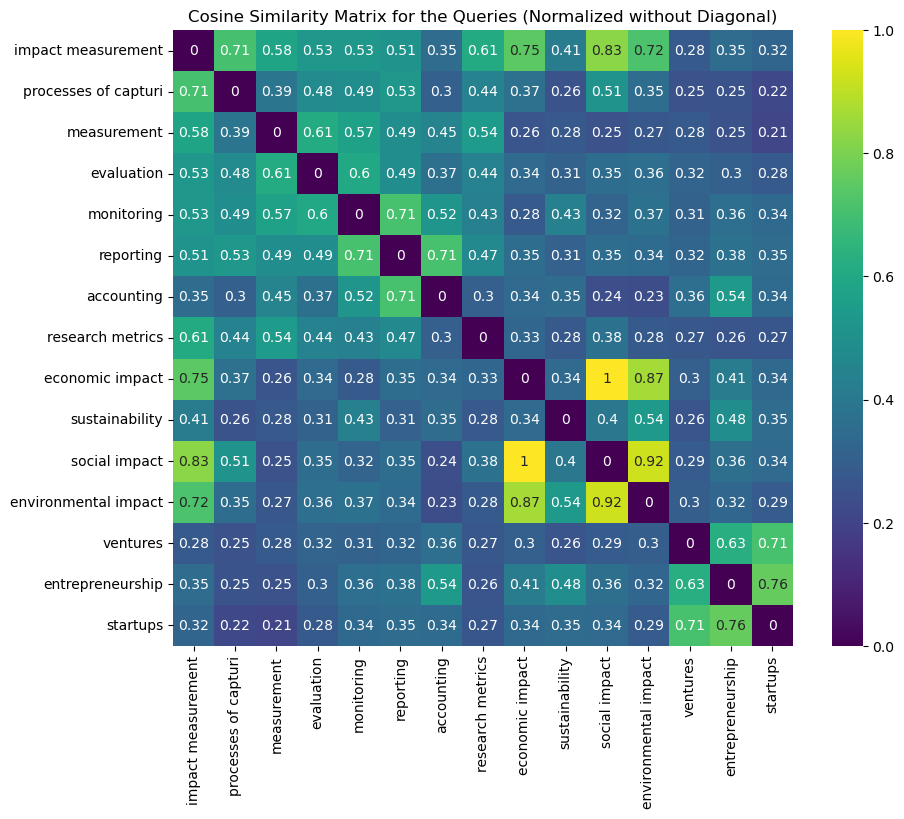

In [34]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the similarity matrix for the queries
query_analyzer = EmbeddingAnalyzer(embeddings, query_list, query_list)
query_similarity = query_analyzer.cosine_similarity_matrix()

# Set the diagonal to zero
query_similarity = query_similarity - query_similarity * np.eye(len(query_similarity))

# Normalize the similarity matrix
query_similarity = (query_similarity - query_similarity.min()) / (query_similarity.max() - query_similarity.min())

# Visualize the similarity matrix as a heatmap
# Cut labels to 20 characters
query_labels = [query[:20] for query in query_list]
plt.figure(figsize=(10, 8))
sns.heatmap(query_similarity, annot=True, xticklabels=query_labels, yticklabels=query_labels, cmap='viridis')
plt.title('Cosine Similarity Matrix for the Queries (Normalized without Diagonal)')
plt.show()